import

In [1]:
%load_ext autoreload
%autoreload 2
import json
import dgl
from sklearn.metrics import f1_score
import torch as th
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.dataloading import GraphDataLoader
import torch.nn.functional as F
import networkx as nx
import warnings
from feature_extraction.base_featurizer import BaseFeaturizer
import torch
from graph_construction.tps_graph import create_dummy_dgl_graph, tps_graph
import numpy as np

from dgl_classifier.trainer import GraphDataset,snap_pred, tps_to_dgl, get_clasification_vec,\
tps_graph_const, extract_data, runner


import warnings

from preprocessing.utils import load_BGPS_from_json
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [2]:
#seed
dgl.seed(1223)

Model

In [3]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.RelGraphConv(in_dim, hidden_dim, 8)
        #self.conv1 = dglnn.GraphConv(in_dim, hidden_ˇdim)
        self.conv2 = dglnn.RelGraphConv(hidden_dim, hidden_dim, 8)
        #self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h, rel_types):
        # Apply graph convolution and activation.
        h = F.relu(self.conv1(g, h, rel_types))
        h = F.relu(self.conv2(g, h, rel_types))
        with g.local_scope():
            g.ndata['node_features'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'node_features')
            return F.softmax( self.classify(hg), dim=1)
model = Classifier(113, 20, 2)

hyperparameters

In [4]:
early_stop =10
model = Classifier(113, 20, 2)
lr = 0.01
wd = 5e-4
epochs = 100
batch_size = 10

file paths

In [5]:
train_file = '/work/data/splits/splits_0.1/train.json'
val_file = '/work/data/splits/splits_0.1/val.json'
test_file = '/work/data/splits/splits_0.1/test.json'
path_to_save = '/work/data/models'
path_to_res = '/work/data/results/25_5_2023_tp_graph_10re.txt'

In [6]:
train_dataloader, val_dataloader, test_dataloader = extract_data(train_file, val_file, test_file, community_no=30, batch_size = batch_size, verbose=False)
print('train dataset', len(train_dataloader)*batch_size)
print('val dataset', len(val_dataloader)*batch_size)
print('test dataset', len(test_dataloader)*batch_size)

train dataset 70
val dataset 30
test dataset 20


/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return th.as_tensor(data, dtype=dtype)


In [7]:
runner(train_dataloader,val_dataloader,test_dataloader,model, early_stop, lr, wd, epochs, path_to_res)

Epoch 1
--------------------------------------------------------------
Epoch:    1        1 Batch loss: 0.679160 Batch F1: 0.33333333333333337
Epoch:    1        2 Batch loss: 0.611328 Batch F1: 0.5
Epoch:    1        3 Batch loss: 0.510151 Batch F1: 0.0
Epoch:    1        4 Batch loss: 0.708731 Batch F1: 0.0
Epoch:    1        5 Batch loss: 0.982889 Batch F1: 0.0
Epoch:    1        6 Batch loss: 0.788462 Batch F1: 0.0
Epoch:    1        7 Batch loss: 0.561194 Batch F1: 0.0
Train Avg Loss    1: 0.691702

Train Avg F1    1: 0.11904761904761905

Val Avg Loss    1: 0.297999

Val Avg F1    1:  0.0

Optimal Val loss (Epoch 1): 0.2979993530946861

Epoch 2
--------------------------------------------------------------
Epoch:    2        1 Batch loss: 0.707315 Batch F1: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch:    2        2 Batch loss: 0.472663 Batch F1: 0.0
Epoch:    2        3 Batch loss: 0.657402 Batch F1: 0.0
Epoch:    2        4 Batch loss: 0.583066 Batch F1: 0.4
Epoch:    2        5 Batch loss: 0.813227 Batch F1: 0.0
Epoch:    2        6 Batch loss: 0.712482 Batch F1: 0.0
Epoch:    2        7 Batch loss: 1.056972 Batch F1: 0.0
Train Avg Loss    2: 0.714732

Train Avg F1    2: 0.05714285714285715

Val Avg Loss    2: 0.596365

Val Avg F1    2:  0.08333333333333333

Optimal Val loss (Epoch 1): 0.2979993530946861

Epoch 3
--------------------------------------------------------------
Epoch:    3        1 Batch loss: 0.809355 Batch F1: 0.0
Epoch:    3        2 Batch loss: 0.708280 Batch F1: 0.33333333333333337
Epoch:    3        3 Batch loss: 0.593176 Batch F1: 0.0
Epoch:    3        4 Batch loss: 0.641657 Batch F1: 0.0
Epoch:    3        5 Batch loss: 0.738643 Batch F1: 0.33333333333333337
Epoch:    3        6 Batch loss: 0.632063 Batch F1: 0.4
Epoch:    3        7 Batch loss: 0.650

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Train Avg Loss   12: 0.551449

Train Avg F1   12: 0.6972789115646257

Val Avg Loss   12: 0.286564

Val Avg F1   12:  0.4222222222222222

Optimal Val loss (Epoch 11): 0.1756366729726627

Epoch 13
--------------------------------------------------------------
Epoch:   13        1 Batch loss: 0.468917 Batch F1: 0.7499999999999999
Epoch:   13        2 Batch loss: 0.480103 Batch F1: 0.888888888888889
Epoch:   13        3 Batch loss: 0.480696 Batch F1: 0.6666666666666666
Epoch:   13        4 Batch loss: 0.607460 Batch F1: 0.6666666666666665
Epoch:   13        5 Batch loss: 0.513187 Batch F1: 0.6666666666666666
Epoch:   13        6 Batch loss: 0.399946 Batch F1: 0.8
Epoch:   13        7 Batch loss: 0.888916 Batch F1: 0.5
Train Avg Loss   13: 0.548461

Train Avg F1   13: 0.7055555555555555

Val Avg Loss   13: 0.179989

Val Avg F1   13:  0.48484848484848486

Optimal Val loss (Epoch 11): 0.1756366729726627

Epoch 14
--------------------------------------------------------------
Epoch:   14      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch:   14        4 Batch loss: 0.373535 Batch F1: 0.8571428571428571
Epoch:   14        5 Batch loss: 0.316622 Batch F1: 1.0
Epoch:   14        6 Batch loss: 0.613934 Batch F1: 0.5714285714285715
Epoch:   14        7 Batch loss: 0.820134 Batch F1: 0.5
Train Avg Loss   14: 0.522022

Train Avg F1   14: 0.7408163265306121

Val Avg Loss   14: 0.556763

Val Avg F1   14:  0.43956043956043955

Optimal Val loss (Epoch 11): 0.1756366729726627

Epoch 15
--------------------------------------------------------------
Epoch:   15        1 Batch loss: 0.870309 Batch F1: 0.3636363636363636
Epoch:   15        2 Batch loss: 0.460644 Batch F1: 0.8333333333333334
Epoch:   15        3 Batch loss: 0.506798 Batch F1: 0.75
Epoch:   15        4 Batch loss: 0.512626 Batch F1: 0.7499999999999999
Epoch:   15        5 Batch loss: 0.813324 Batch F1: 0.6153846153846153
Epoch:   15        6 Batch loss: 0.419943 Batch F1: 0.6666666666666666
Epoch:   15        7 Batch loss: 0.314551 Batch F1: 1.0
Train Avg Loss   15

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch:   17        1 Batch loss: 0.524839 Batch F1: 0.6666666666666666
Epoch:   17        2 Batch loss: 0.509582 Batch F1: 0.6666666666666666
Epoch:   17        3 Batch loss: 0.613728 Batch F1: 0.5714285714285715
Epoch:   17        4 Batch loss: 0.625389 Batch F1: 0.6666666666666665
Epoch:   17        5 Batch loss: 0.339219 Batch F1: 1.0
Epoch:   17        6 Batch loss: 0.478136 Batch F1: 0.888888888888889
Epoch:   17        7 Batch loss: 0.742516 Batch F1: 0.5714285714285715
Train Avg Loss   17: 0.547630

Train Avg F1   17: 0.7188208616780045

Val Avg Loss   17: 0.195925

Val Avg F1   17:  0.7481481481481481

Optimal Val loss (Epoch 11): 0.1756366729726627

Epoch 18
--------------------------------------------------------------
Epoch:   18        1 Batch loss: 0.502735 Batch F1: 0.7499999999999999
Epoch:   18        2 Batch loss: 0.332311 Batch F1: 1.0
Epoch:   18        3 Batch loss: 0.715094 Batch F1: 0.6
Epoch:   18        4 Batch loss: 0.789860 Batch F1: 0.4444444444444444
Epoch: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch:   20        5 Batch loss: 0.539485 Batch F1: 0.6666666666666665
Epoch:   20        6 Batch loss: 0.524259 Batch F1: 0.6666666666666666
Epoch:   20        7 Batch loss: 0.520078 Batch F1: 0.6666666666666666
Train Avg Loss   20: 0.520181

Train Avg F1   20: 0.678726035868893

Val Avg Loss   20: 0.279195

Val Avg F1   20:  0.7666666666666667

Optimal Val loss (Epoch 11): 0.1756366729726627

Epoch 21
--------------------------------------------------------------
Epoch:   21        1 Batch loss: 0.364438 Batch F1: 0.8571428571428571
Epoch:   21        2 Batch loss: 0.468036 Batch F1: 0.75
Epoch:   21        3 Batch loss: 0.618055 Batch F1: 0.6666666666666666
Epoch:   21        4 Batch loss: 0.460504 Batch F1: 0.5
Epoch:   21        5 Batch loss: 0.416053 Batch F1: 0.8
Epoch:   21        6 Batch loss: 0.716779 Batch F1: 0.6
Epoch:   21        7 Batch loss: 0.541057 Batch F1: 0.75
Train Avg Loss   21: 0.512132

Train Avg F1   21: 0.7034013605442176

Val Avg Loss   21: 0.313424

Val Avg

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch:   25        5 Batch loss: 0.763707 Batch F1: 0.6
Epoch:   25        6 Batch loss: 0.360837 Batch F1: 0.923076923076923
Epoch:   25        7 Batch loss: 0.362911 Batch F1: 1.0
Train Avg Loss   25: 0.483243

Train Avg F1   25: 0.7747252747252747

Val Avg Loss   25: 0.464451

Val Avg F1   25:  0.4468864468864469

Optimal Val loss (Epoch 11): 0.1756366729726627

Epoch 26
--------------------------------------------------------------
Epoch:   26        1 Batch loss: 0.475229 Batch F1: 0.888888888888889
Epoch:   26        2 Batch loss: 0.680871 Batch F1: 0.3333333333333333
Epoch:   26        3 Batch loss: 0.514487 Batch F1: 0.8
Epoch:   26        4 Batch loss: 0.477807 Batch F1: 0.75
Epoch:   26        5 Batch loss: 0.318785 Batch F1: 1.0
Epoch:   26        6 Batch loss: 0.513416 Batch F1: 0.6666666666666666
Epoch:   26        7 Batch loss: 0.429337 Batch F1: 0.8571428571428571
Train Avg Loss   26: 0.487133

Train Avg F1   26: 0.7565759637188209

Val Avg Loss   26: 0.192565

Val Avg F

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch:   29        1 Batch loss: 0.447494 Batch F1: 0.888888888888889
Epoch:   29        2 Batch loss: 0.449758 Batch F1: 0.8
Epoch:   29        3 Batch loss: 0.595845 Batch F1: 0.33333333333333337
Epoch:   29        4 Batch loss: 0.656765 Batch F1: 0.6666666666666666
Epoch:   29        5 Batch loss: 0.513471 Batch F1: 0.75
Epoch:   29        6 Batch loss: 0.315431 Batch F1: 1.0
Epoch:   29        7 Batch loss: 0.402954 Batch F1: 0.8
Train Avg Loss   29: 0.483103

Train Avg F1   29: 0.7484126984126984

Val Avg Loss   29: 0.178858

Val Avg F1   29:  0.7802197802197802

Optimal Val loss (Epoch 11): 0.1756366729726627

Epoch 30
--------------------------------------------------------------
Epoch:   30        1 Batch loss: 0.514241 Batch F1: 0.6666666666666666
Epoch:   30        2 Batch loss: 0.477302 Batch F1: 0.75
Epoch:   30        3 Batch loss: 0.434452 Batch F1: 0.9090909090909091
Epoch:   30        4 Batch loss: 0.493581 Batch F1: 0.7499999999999999
Epoch:   30        5 Batch loss: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Train Avg Loss   33: 0.483443

Train Avg F1   33: 0.7214285714285715

Val Avg Loss   33: 0.207183

Val Avg F1   33:  0.6190476190476191

Optimal Val loss (Epoch 11): 0.1756366729726627

Epoch 34
--------------------------------------------------------------
Epoch:   34        1 Batch loss: 0.548831 Batch F1: 0.7499999999999999
Epoch:   34        2 Batch loss: 0.444712 Batch F1: 0.9090909090909091
Epoch:   34        3 Batch loss: 0.617362 Batch F1: 0.5
Epoch:   34        4 Batch loss: 0.514056 Batch F1: 0.5
Epoch:   34        5 Batch loss: 0.413855 Batch F1: 0.888888888888889
Epoch:   34        6 Batch loss: 0.458826 Batch F1: 0.0
Epoch:   34        7 Batch loss: 0.368203 Batch F1: 0.8
Train Avg Loss   34: 0.480835

Train Avg F1   34: 0.6211399711399712

Val Avg Loss   34: 0.475032

Val Avg F1   34:  0.49999999999999994

Optimal Val loss (Epoch 11): 0.1756366729726627

Early Stopping invoked after epoch 34
Done!


In [8]:
import json

In [9]:
results = json.load(open(path_to_res))

In [10]:
results

{'train_loss': [0.6917022040912083,
  0.7147323404039655,
  0.6818867666380746,
  0.6722474013056073,
  0.6585073556218829,
  0.6221291167395455,
  0.5619691482612065,
  0.5578065259116036,
  0.5786970130034855,
  0.5351510643959045,
  0.5719756313732692,
  0.5514486474650246,
  0.5484607347420284,
  0.5220215150288173,
  0.5568849955286298,
  0.5192995667457581,
  0.5476298757961818,
  0.5231812213148389,
  0.5351806921618325,
  0.5201811790466309,
  0.512131827218192,
  0.5223340562411717,
  0.5036049144608634,
  0.49083726746695383,
  0.4832427373954228,
  0.48713323048182894,
  0.49614753467696054,
  0.4898046978882381,
  0.4831026111330305,
  0.4843725178922926,
  0.5000722237995693,
  0.48533110533441814,
  0.48344304731913973,
  0.48083499925477163],
 'val_loss': [0.2979993530946861,
  0.5963645478089651,
  0.5883939266204834,
  0.5884711444377899,
  0.5959836741288503,
  0.23030821482340494,
  0.474165399869283,
  0.220113605260849,
  0.4375632703304291,
  0.1904706728334228,
 

In [11]:
list(results.keys())

['train_loss', 'val_loss', 'test_loss', 'train_f1', 'val_f1', 'test_f1']

In [15]:
print('best f1', np.max(results['val_f1']), np.argmax(results['val_f1']))
print('best f1 val', results['val_f1'][np.argmax(results['val_f1'])])
print('corr f1 train', results['train_f1'][np.argmax(results['val_f1'])])
print('corr f1 test', results['test_f1'][np.argmax(results['val_f1'])])
print('best f1 train', np.max(results['train_f1']), np.argmax(results['train_f1']))

best f1 0.8114478114478114 9
best f1 val 0.8114478114478114
corr f1 train 0.6144403215831787
corr f1 test 0.6615384615384615
best f1 train 0.7747252747252747 24


In [17]:
import matplotlib.pyplot as plt

(0.0, 1.0)

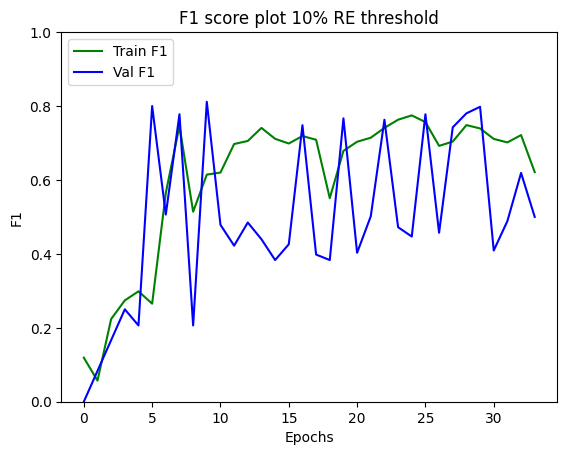

In [19]:
plt.title('F1 score plot 10% RE threshold')
plt.ylabel('F1')
plt.xlabel('Epochs')
plt.plot(results['train_f1'],'-g', label='Train F1')
plt.plot(results['val_f1'],'-b', label='Val F1')
plt.legend(loc='upper left')
plt.ylim([0.0,1.0])